In [ ]:
import numpy as np
import copy 
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from matplotlib import animation, rc
rc('animation', html='jshtml')
from matplotlib import cm
from matplotlib import gridspec


In [67]:
### Running with mean least squares loss and early stopping on validationset 

class NeuralNet4:
    def __init__(self, N_features=1, N_HL_neurons=5,N_epochs=100,
                        batch_size = 32, learning_rate = 0.01, stagnation_nr = 20): 

        self.params             = self.get_init_params(N_features,N_HL_neurons,1)
        self.cost_history       = None
        self.param_history      = None
        self.N_epochs           = N_epochs 
        self.batch_size         = batch_size
        self.learning_rate      = learning_rate
        self.stagnation_nr      = stagnation_nr
        self.best_params        = None

    def splitting(self,X):
        '''Method for splitting data into a training set and a validation set
            validation_set is a random "percentage" size of data '''
            
        percentage = 0.3
        validation_set = np.random.permutation(X)[:int(percentage*X.shape[0])]
        mask = np.in1d(X,validation_set,invert=True)
        training_set = X[mask]
        return validation_set, training_set

    def ReLU(self,X):
        """ Compute the activation function on every element of the input by means of ReLU

            Args:
                X: np.array
            Returns:
                res: np.array same shape as X
        """
        # ReLU
        res = np.copy(X)
        res[X <= 0] = 0
        return res

    def ReLU_deriv(self, X):
        """ Compute the derivative of activation function (RelU) on every element of the input

            Args:
                X: np.array
            Returns:
                res: np.array same shape as X
        """
        # ReLU
        res = np.ones(X.shape)
        res[X <= 0] = 0
        return res

    def make_dict(self,W1, b1, W2, b2):
        """ Trivial helper function """
        return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    def get_init_params(self,input_dim, hidden_size, output_size):
        """ Initializer function using:
        Understanding the difficulty of training deep feedforward neural networks
        http://proceedings.mlr.press/v9/glorot10a.html


        Args:
        input_dim: int
        hidden_size: int
        output_size: int
        Returns:
        dict of randomly initialized parameter matrices.
        """
        W1 = np.random.uniform(0, np.sqrt(6./(input_dim+hidden_size)), size=(hidden_size, input_dim))
        b1 = np.zeros((hidden_size,1))
        W2 = np.random.uniform(0, np.sqrt(6./(hidden_size+output_size)), size=(hidden_size, output_size))
        b2 = np.zeros((output_size,1))

        return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    def predict(self, X, params):
            """ Compute prediction for all data points in class X
            
            Args:
                X: np.array shape n, d
                params: dict of params to use (if none use stored params)
            Returns:
                np.array shape n, 1
            """
            n          = X.shape[0]
            prediction = np.zeros(n)

            # Computing forward pass #
            for i in range(n):
                a = np.array(X[i]).T*params['W1']
                b = a + params['b1']
                c = self.ReLU(b)
                d = c.T@params['W2']
                e = d + params['b2']
                prediction[i] = e

            return prediction


    def cost_grad(self,X, y, params):
            """ Compute cost and gradient of neural net on data X with labels y using weight decay parameter c
            You should implement a forward pass and store the intermediate results 
            and the implement the backwards pass using the intermediate stored results
            
            Use the derivative for cost as a function for input to softmax as derived above
            
            Args:
                X: np.array shape n, self.input_size
                y: np.array shape n, 1
                params: dict with keys (W1, W2, b1, b2)
                c: float - weight decay parameter
                params: dict of params to use for the computation
            
            Returns 
                cost: scalar - average cross entropy cost
                dict with keys
                d_w1: np.array shape w1.shape, entry d_w1[i, j] = \partial cost/ \partial W1[i, j]
                d_w2: np.array shape w2.shape, entry d_w2[i, j] = \partial cost/ \partial W2[i, j]
                d_b1: np.array shape b1.shape, entry d_b1[1, j] = \partial cost/ \partial b1[1, j]
                
            """
            W1 = params['W1']
            b1 = params['b1']
            W2 = params['W2']
            b2 = params['b2']

            cost, n    = 0.0, X.shape[0]
            deriv_dict = self.make_dict(np.zeros(W1.shape),np.zeros(b1.shape),np.zeros(W2.shape),np.zeros(b2.shape))
            for i in range(n):
                # Computing forward pass #
                a = np.array(X[i]).T*W1 
                b = a+b1 
                c = self.ReLU(b)
                d = c.T@W2
                e = d+b2
                f = np.power(e-y[i],2)/n
                g = f
                cost += g

                # Computing backpropagation #
                dg_dg  = 1.0
                dg_df  = 1.0
                dg_de  = 2.0*(e-y[i])/n
                dg_db2 = dg_de
                dg_dd  = dg_de
                dg_dW2 = dg_dd*c
                dg_dc  = dg_dd*W2
                dg_db  = dg_dd*self.ReLU_deriv(b)*W2
                dg_db1 = dg_db
                dg_da  = dg_db
                dg_dW1 = dg_db*np.array(X[i])

                deriv_dict['W1'] += dg_dW1
                deriv_dict['b1'] += dg_db1
                deriv_dict['W2'] += dg_dW2
                deriv_dict['b2'] += dg_db2
            
            return cost, {'d_W1': deriv_dict['W1'], 'd_b1': deriv_dict['b1'], 'd_W2': deriv_dict['W2'], 'd_b2': deriv_dict['b2']}
        
    def fit(self, X_train, y_train, init_params):
            """ Run Mini-Batch Gradient Descent on data X, Y to minimize the in sample error for Neural Net classification
        
            Args:
            X_train: numpy array shape (n, d) - the training data each row is a data point
            y_train: numpy array shape (n,)   - training target labels 

            init_params: dict - has initial setting of parameters

            Sets: 
            params: dict with keys {W1, W2, b1,} parameters for neural net
            returns
            hist: dict:{keys: train_loss, train_acc, val_loss, val_acc} each an np.array of size epochs of the the given cost after every epoch
            loss is the NLL loss and acc is accuracy
            """
            

            params                 = init_params
            param_history          = []
            no_improvement_counter = 0
            
            train_cost = np.zeros(self.N_epochs)
            valid_cost = np.zeros(self.N_epochs)

            validation_x, training_x = self.splitting(X_train)
            validation_y, training_y = self.splitting(y_train)

            assert self.batch_size <= training_x.shape[0] , 'Batch size is bigger than size of training set'

 
            param_history.append(copy.deepcopy(params))                            ## Appending initial params to history
            self.best_params = params                                              ## Initial best params
            best_train_cost ,_ = self.cost_grad(training_x,training_y,params)      ## Initial training cost
            best_valid_cost ,_ = self.cost_grad(validation_x,validation_y,params)  ## Initial validation cost
            for i in range(self.N_epochs):

                X_perm = np.random.permutation(training_x)
                Y_perm = np.random.permutation(training_y)
                X_batch, Y_batch = X_perm[:self.batch_size], Y_perm[:self.batch_size]

                # Gradient run #
                for j in range(X_train.shape[0]//self.batch_size):
                    _, grad = self.cost_grad(X_batch,Y_batch,params)
                    params['W1'] -= self.learning_rate*grad['d_W1']
                    params['b1'] -= self.learning_rate*grad['d_b1']
                    params['W2'] -= self.learning_rate*grad['d_W2']
                    params['b2'] -= self.learning_rate*grad['d_b2']

                # Calculating cost at current epoch #
                current_train_cost ,_ = self.cost_grad(training_x,training_y,params)
                current_valid_cost ,_ = self.cost_grad(validation_x,validation_y,params)

                # Appending value of cost function at current epoch #
                train_cost[i] = current_train_cost
                valid_cost[i] = current_valid_cost

                # Checking validation cost 
                if current_valid_cost < best_valid_cost:
                    best_valid_cost = current_valid_cost
                else:
                    no_improvement_counter += 1

                # Checking training cost
                if current_train_cost < best_train_cost:
                    best_train_cost = current_train_cost
                    self.best_params = params
                
                # Checking for termination 
                if no_improvement_counter >= self.stagnation_nr:
                    print(f'##### No improvement in validation cost ######')
                    print(f'terminated after {i} epochs')
                    break

                param_history.append(copy.deepcopy(params)) ## Appending current params to history
            
            self.param_history = param_history
            self.cost_history = {'train_cost': train_cost, 'valid_cost': valid_cost}
            self.params = {'W1': params['W1'], 'b1': params['b1'], 'W2': params['W2'], 'b2': params['b2']}
          



##### No improvement in validation cost ######
terminated after 148 epochs


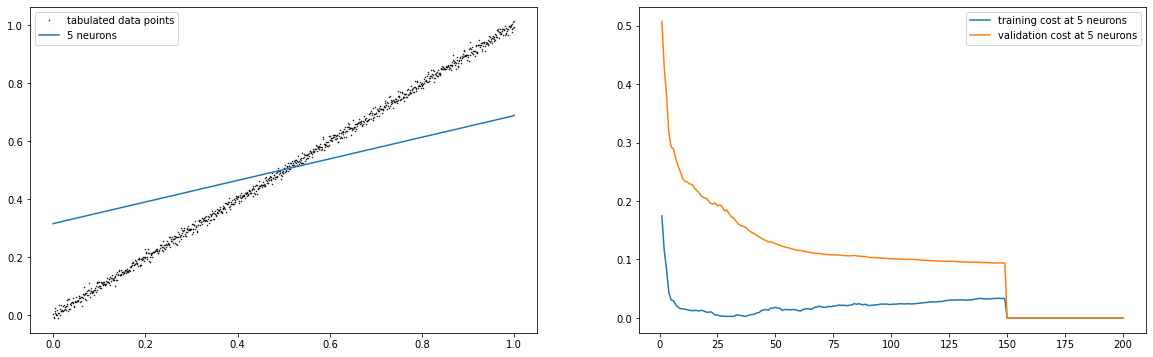

In [78]:
%matplotlib inline

N_points = 1000
mu = 0
sigma = 0.01
def func(x):
    return x

xs = np.linspace(0,1.0,N_points)
ys = func(xs) + np.random.normal(mu,sigma,size=N_points)


N_epoch = 200
lr = 0.0005
batch_size = 20
n_units = 5

test1 = NeuralNet4(N_HL_neurons=n_units,N_epochs=N_epoch,learning_rate=lr,batch_size=batch_size)
test1.fit(xs,ys,test1.params)
prediction1 = test1.predict(xs,test1.best_params)

fig, ax = plt.subplots(1,2,figsize=(20,6))

ax[0].plot(xs,ys,'ko',ms=0.5,label='tabulated data points')

ax[0].plot(xs,prediction1,label=str(n_units)+' neurons')

ax[1].plot(np.arange(1,len(test1.cost_history['train_cost'])+1,1),test1.cost_history['train_cost'],label='training cost at '+str(n_units)+' neurons')
ax[1].plot(np.arange(1,len(test1.cost_history['valid_cost'])+1,1),test1.cost_history['valid_cost'],label='validation cost at '+str(n_units)+' neurons')

ax[0].legend()
ax[1].legend()



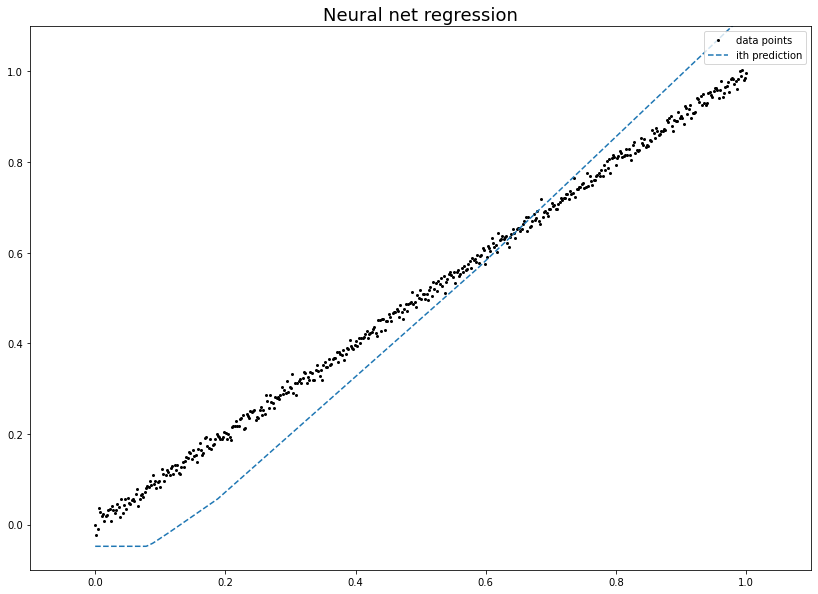

In [73]:
predictions = []
for i in range(10):
    predictions.append(test1.predict(xs,test1.param_history[i]))
    
## Defining plot ##
## Defining x- & y-limits for plot ##

fig, ax = plt.subplots(1,1,figsize = (14,10))
ax.set_title('Neural net regression',size=18)
ax.plot(xs,ys,'ko',label='data points',ms=2)

NN_predictions, = ax.plot([],[],'--',color='tab:blue',label='ith prediction')


def update(i):
    NN_predictions.set_data(xs,predictions[i])

    return NN_predictions,


ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.legend(loc='upper right')

anim = animation.FuncAnimation(fig,
                               update,
                               frames=len(predictions),
                               interval=70,
                               blit=True,
                               repeat_delay=0)
# Set up formatting for the movie files

## uncomment below to save gif ##
#writergif = animation.PillowWriter(fps=3) 
#anim.save("BinaryGA_2.gif", writer=writergif)

anim